<a href="https://colab.research.google.com/github/MarcoE25/Clases-Analisis-Datos/blob/main/Clase_6_intermedio_202508.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comenzamos 7:32 pm

# 🚀 Itinerario de clase

* Índices
* Tablas dinámicas
* Iteración sobre dataframes

In [ ]:
# PONER EN LA PRIMER CELDA TODAS LAS LIBRERÍAS
import pandas as pd
from dateutil import parser
import datetime as dt
import random as r

# Webscraping
import urllib.request, json
from urllib.request import urlopen
from zipfile import ZipFile
import re
import requests

## Cargamos la información



In [ ]:
################################################################################
############################ CARGA DE LA INFORMACION ###########################
################################################################################
df_bank = pd.read_csv("https://cursopypagina.github.io/CursoPy/Clase_1.csv")
df_bank_ej = pd.read_csv("https://cursopypagina.github.io/CursoPy/Clase_1_5.csv")

df_bank_ej = df_bank_ej.rename(columns={"Fecha_Inicio_Contrato": "Fecha_Inicio"})
df_bank_ej = df_bank_ej[["Nombre_Empresa", "Ejecutivo", "Fecha_Inicio"]]

################################################################################
############################ VALORES DEL USD-EUR ###############################
################################################################################
def divisa_webs(clave):
  url = "https://www.piplatam.com/Home/filiales?country=MX"
  page = urlopen(url)
  htmlBytes = page.read()
  html = htmlBytes.decode("utf-8")
  strValorClave = html.find(clave)
  stringFiltro1 = html[strValorClave:]
  strValor = stringFiltro1.split("dblValue")[1].split("dblChange")[0]
  strValor = re.findall(r"\d+\.\d+", strValor)[0]
  return strValor

usdValor = round(float(divisa_webs("USD-MXN FIX (Banxico)")), 2)
eurValor = round(float(divisa_webs("EUR-MXN")), 2)

################################################################################
########################## LIMPIEZA Y PROCESAMIENTO ############################
################################################################################
def clean_1(df_func, tipo):
  df_func_trabajo = df_func.copy()
  df_func_trabajo['Nombre_Empresa'] = df_func_trabajo['Nombre_Empresa'].str.strip().str.title()
  df_func_trabajo["Fecha_Inicio"] = df_func_trabajo["Fecha_Inicio"].apply(lambda x: parser.parse(x))

  if tipo == "Ejecutivo":
    return df_func_trabajo
  elif tipo == "General":
    df_func_trabajo['Fecha_Fin'] = df_func_trabajo['Fecha_Fin'].fillna('1900-01-01')
    df_func_trabajo['Plazo'] = df_func_trabajo['Plazo'].fillna(0)
    df_func_trabajo['Plazo'] = df_func_trabajo['Plazo'].astype(int)

    df_func_trabajo['Fecha_Fin'] = df_func_trabajo['Fecha_Fin'].apply(lambda x: parser.parse(x))
    df_func_trabajo['Operacion'] = df_func_trabajo['Operacion'].str.split("-").apply(lambda x: x[1])

    fechaReporte = dt.datetime.today() - dt.timedelta(days = 1)
    fechaReporte = dt.datetime.strftime(fechaReporte, "%Y-%m-%d")
    df_func_trabajo['Fecha_Reporte'] = fechaReporte

    # Columnas condicionales
    zonas = ["Norte", "Sur", "Centro"]
    df_func_trabajo['Zonas'] = [r.choice(zonas) for i in range(len(df_func_trabajo))]

    def valorizador(divisa):
      if divisa == "USD":
        return usdValor
      elif divisa == "EUR":
        return eurValor
      else:
        return 1
    df_func_trabajo['Divisa_Valor'] = df_func_trabajo['Divisa'].apply(valorizador)
    df_func_trabajo['Monto_Credito'] = df_func_trabajo['Monto_Credito'] * df_func_trabajo['Divisa_Valor']
    del df_func_trabajo['Divisa_Valor']

    return df_func_trabajo
  else:
    print("⚠️Nombre inválido⚠️")

################################################################################
##################### APLICAMOS LA FUNCION DE LIMPIEZA #########################
################################################################################
df_bank_clean = clean_1(df_bank, "General")
df_bank_clean_ej = clean_1(df_bank_ej, "Ejecutivo")

## Nos quedamos solo con un ejecutivo por empresa

In [ ]:
# Nos quedamos con el ultimo ejecutivo via fecha de inicio
df_bank_clean_ej_clean = df_bank_clean_ej.groupby("Nombre_Empresa").agg(
    {
        "Fecha_Inicio": ['max'],
        "Ejecutivo": ['last']
    }
)
df_bank_clean_ej_clean = df_bank_clean_ej_clean.reset_index()
# Accedemos a las columnas de nuestro dataframe
df_bank_clean_ej_clean.columns = ['Nombre_Empresa', 'Fecha_Inicio', 'Ejecutivo']
df_bank_clean_ej_clean.head()

,Nombre_Empresa,Fecha_Inicio,Ejecutivo
0,Alsea,2025-08-12,Sandra Rodolfo Amador
1,América Móvil,2025-07-06,Cristobal Miguel Ángel Armenta Mayorga
2,Banorte,2025-08-03,Eloisa Salinas Aguilar
3,Bbva México,2025-07-30,Víctor Durán de la Crúz
4,Cemex,2025-07-28,Francisco Bustos Nájera


## Comprobamos si ya no hay repetidos

In [ ]:
df_bank_clean_ej_gby = df_bank_clean_ej_clean[['Nombre_Empresa', "Fecha_Inicio"]].groupby("Nombre_Empresa").count().reset_index()
# Valores unicos de esa columna (eliminar duplicados)-con objetivo de visualizacion
df_bank_clean_ej_gby['Fecha_Inicio'].unique()

array([1])

## Repasamos el tema de filtros buscando el crédito de mayor monto

In [ ]:
# Caracteristicas del credito de mayor monto
# mask_booleana_max_credito = (df_bank_clean['Monto_Credito'] == 9998263.92)
mask_booleana_max_credito = (df_bank_clean['Monto_Credito'] == df_bank_clean['Monto_Credito'].max())
df_bank_clean[mask_booleana_max_credito]

,Nombre_Empresa,Monto_Credito,Divisa,Operacion,Fecha_Inicio,Fecha_Fin,Plazo,Fecha_Reporte,Zonas
2592,Banorte,2.174582e+08,EUR,102592,2020-11-02,2021-08-27,298,2025-09-10,Centro


# Merges

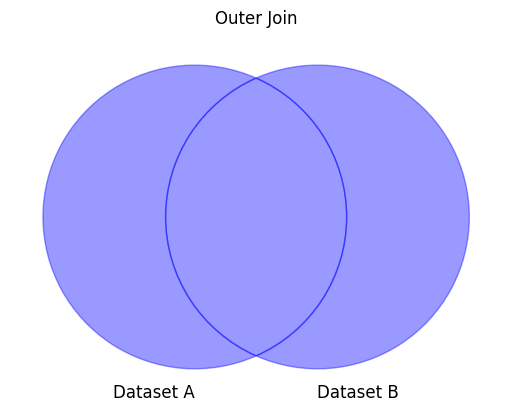

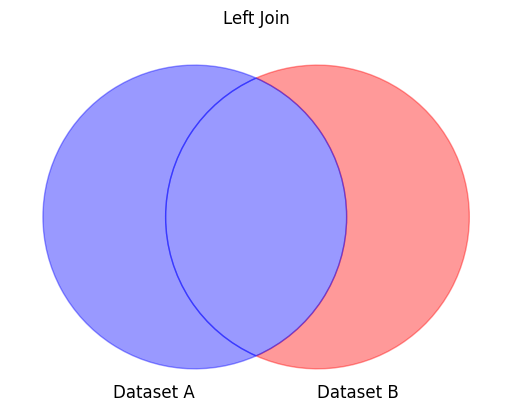

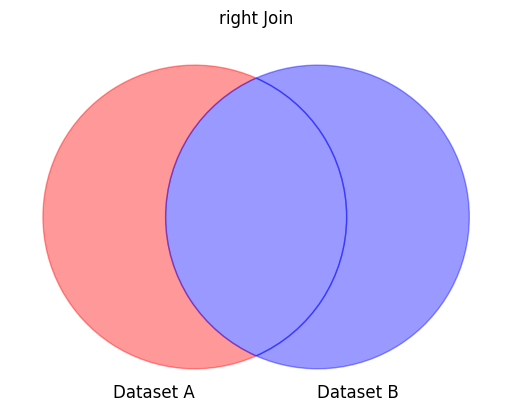

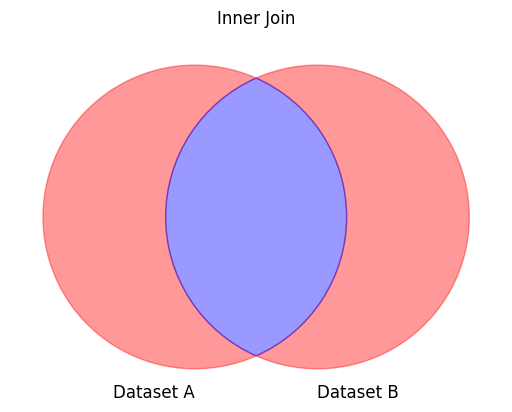

In [ ]:
# @title
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import warnings
warnings.filterwarnings('ignore')
# definimos un diagrama de venn
venn1 = venn2((1,1,1),
              set_labels = ('Dataset A', 'Dataset B'))

# configuramos un mismo color para las tres partes
venn1.get_patch_by_id('10').set_color('blue')
venn1.get_patch_by_id('11').set_color('blue')
venn1.get_patch_by_id('01').set_color('blue')

# Para quitar los unos que se ven por defecto
# colocamos como etiquetas cadenas vacias
venn1.get_label_by_id('10').set_text('')
venn1.get_label_by_id('11').set_text('')
venn1.get_label_by_id('01').set_text('')

plt.title('Outer Join')
plt.show()

# definimos un diagrama de venn
venn1 = venn2((1,1,1),
              set_labels = ('Dataset A', 'Dataset B'))

# configuramos un mismo color para las tres partes
venn1.get_patch_by_id('10').set_color('blue')
venn1.get_patch_by_id('11').set_color('blue')
venn1.get_patch_by_id('01').set_color('red')

# Para quitar los unos que se ven por defecto
# colocamos como etiquetas cadenas vacias
venn1.get_label_by_id('10').set_text('')
venn1.get_label_by_id('11').set_text('')
venn1.get_label_by_id('01').set_text('')

plt.title('Left Join')
plt.show()

venn1 = venn2((1,1,1),
              set_labels = ('Dataset A', 'Dataset B'))

# configuramos un mismo color para las tres partes
venn1.get_patch_by_id('10').set_color('red')
venn1.get_patch_by_id('11').set_color('blue')
venn1.get_patch_by_id('01').set_color('blue')

# Para quitar los unos que se ven por defecto
# colocamos como etiquetas cadenas vacias
venn1.get_label_by_id('10').set_text('')
venn1.get_label_by_id('11').set_text('')
venn1.get_label_by_id('01').set_text('')

plt.title('right Join')
plt.show()


# definimos un diagrama de venn
venn1 = venn2((1,1,1),
              set_labels = ('Dataset A', 'Dataset B'))

# configuramos un mismo color para las tres partes
venn1.get_patch_by_id('10').set_color('red')
venn1.get_patch_by_id('11').set_color('blue')
venn1.get_patch_by_id('01').set_color('red')

# Para quitar los unos que se ven por defecto
# colocamos como etiquetas cadenas vacias
venn1.get_label_by_id('10').set_text('')
venn1.get_label_by_id('11').set_text('')
venn1.get_label_by_id('01').set_text('')

plt.title('Inner Join')
plt.show()

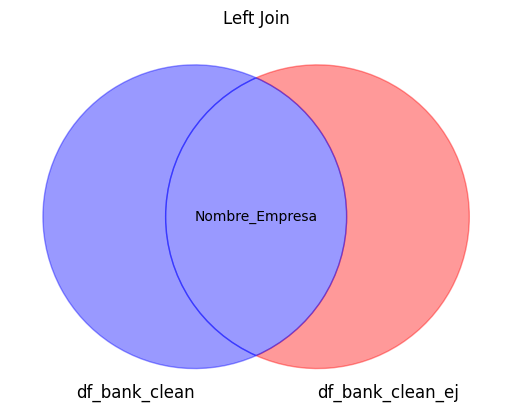

In [ ]:
# @title Texto de título predeterminado
# definimos un diagrama de venn
venn1 = venn2((1,1,1),
              set_labels = ('df_bank_clean', 'df_bank_clean_ej'))

# configuramos un mismo color para las tres partes
venn1.get_patch_by_id('10').set_color('blue')
venn1.get_patch_by_id('11').set_color('blue')
venn1.get_patch_by_id('01').set_color('red')

# Para quitar los unos que se ven por defecto
# colocamos como etiquetas cadenas vacias
venn1.get_label_by_id('10').set_text('')
venn1.get_label_by_id('11').set_text('Nombre_Empresa')
venn1.get_label_by_id('01').set_text('')

plt.title('Left Join')
plt.show()

In [ ]:
# si quieres ejecutar toda una libreta y quieres poner un punto de "ruptura" del
# flujo de ejecucion:
# raise

In [ ]:
print(df_bank_clean.columns)
print(df_bank_clean_ej.columns)

Index(['Nombre_Empresa', 'Monto_Credito', 'Divisa', 'Operacion',
       'Fecha_Inicio', 'Fecha_Fin', 'Plazo', 'Fecha_Reporte', 'Zonas'],
      dtype='object')
Index(['Nombre_Empresa', 'Ejecutivo', 'Fecha_Inicio'], dtype='object')


In [ ]:
# Eliminamos la columna de fecha de inicio
del df_bank_clean_ej_clean['Fecha_Inicio']

In [ ]:
# datasetA.merge(datasetB, on="nombreColumnaPuente") ---> por defecto se hace el inner
# datasetA.merge(datasetB, on="nombreColumnaPuente", how="left"/"right"/"outer")
df_bank_clean.merge(df_bank_clean_ej_clean, on='Nombre_Empresa', how='left', suffixes=["_A", "_B"])

,Nombre_Empresa,Monto_Credito,Divisa,Operacion,Fecha_Inicio,Fecha_Fin,Plazo,Fecha_Reporte,Zonas,Ejecutivo
0,Grupo Bimbo,4.117590e+06,MXN,100000,2019-08-27,2023-04-24,1336,2025-09-10,Norte,Luis Manuel Ana María Vera Domínguez
1,Walmart De México,1.302792e+08,USD,100001,2017-04-10,2022-02-18,1775,2025-09-10,Norte,Eloisa Salinas Aguilar
2,Liverpool,2.158195e+08,EUR,100002,2017-04-21,1900-01-01,0,2025-09-10,Norte,Dr. Virginia Pelayo
3,Grupo Lala,2.403768e+07,USD,100003,2023-11-24,1900-01-01,0,2025-09-10,Norte,Juana Antonia Lira Samaniego
4,Femsa,1.551194e+08,EUR,100004,2024-10-30,1900-01-01,0,2025-09-10,Sur,Gabino Mariano Laureano Puente
...,...,...,...,...,...,...,...,...,...,...
9995,Bbva México,7.649614e+06,MXN,109995,2021-01-02,2023-03-01,788,2025-09-10,Centro,Víctor Durán de la Crúz
9996,Soriana,1.578366e+06,MXN,109996,2017-02-28,2022-02-12,1810,2025-09-10,Sur,Alfonso Natalia Sevilla
9997,Walmart De México,2.057032e+06,MXN,109997,2020-05-19,1900-01-01,0,2025-09-10,Norte,Eloisa Salinas Aguilar
9998,Grupo Bimbo,6.555259e+06,MXN,109998,2017-05-13,2019-12-24,955,2025-09-10,Centro,Luis Manuel Ana María Vera Domínguez


In [ ]:
# raise

In [ ]:
df_bank_final = df_bank_clean.merge(df_bank_clean_ej_clean, on='Nombre_Empresa', how='left')
df_bank_final.head()

,Nombre_Empresa,Monto_Credito,Divisa,Operacion,Fecha_Inicio,Fecha_Fin,Plazo,Fecha_Reporte,Zonas,Ejecutivo
0,Grupo Bimbo,4.117590e+06,MXN,100000,2019-08-27,2023-04-24,1336,2025-09-10,Norte,Luis Manuel Ana María Vera Domínguez
1,Walmart De México,1.302792e+08,USD,100001,2017-04-10,2022-02-18,1775,2025-09-10,Norte,Eloisa Salinas Aguilar
2,Liverpool,2.158195e+08,EUR,100002,2017-04-21,1900-01-01,0,2025-09-10,Norte,Dr. Virginia Pelayo
3,Grupo Lala,2.403768e+07,USD,100003,2023-11-24,1900-01-01,0,2025-09-10,Norte,Juana Antonia Lira Samaniego
4,Femsa,1.551194e+08,EUR,100004,2024-10-30,1900-01-01,0,2025-09-10,Sur,Gabino Mariano Laureano Puente


# Análisis de datos

1. Preprocesamiento (80%)
2. Análisis (20%)

### Ejercicios

1. ¿Cuánto nos deben por zona?
2. ¿Cuánto debe en total bimbo?
3. Crea un función para saber lo anterior dependiende del nombre de la empresa
4. ¿Cuánto nos deben por divisa?
5. Crea un columna condicional con tasas

In [ ]:
# 1. Cifra por una columna categorica
#    suma del monto del credito por zona
#    sum() ------------> groupby(zona)
df_sum_creditos_zona = df_bank_final[['Zonas', 'Monto_Credito']].groupby('Zonas').sum().reset_index()
df_sum_creditos_zona['Monto_Credito'] = df_sum_creditos_zona['Monto_Credito'].apply(lambda x: f"{x:,}")
df_sum_creditos_zona

,Zonas,Monto_Credito
0,Centro,"234,513,293,435.1733"
1,Norte,"234,504,819,007.0202"
2,Sur,"239,079,457,484.2991"


In [ ]:
# 4.
df_sum_creditos_Divisa = df_bank_final[['Divisa', 'Monto_Credito']].groupby('Divisa').sum().reset_index()
df_sum_creditos_Divisa['Monto_Credito'] = df_sum_creditos_Divisa['Monto_Credito'].apply(lambda x: f"{x:,}")
df_sum_creditos_Divisa

,Divisa,Monto_Credito
0,EUR,"373,679,585,450.5216"
1,MXN,"16,501,540,339.68"
2,USD,"317,916,444,136.291"


In [ ]:
# 2. Cuanto debe bimbo
# 1. Filtrar a bimbo
# 2. sum() sobre "algo"
mask_booleano_bimbo = df_bank_final['Nombre_Empresa'] == "Grupo Bimbo"
df_bank_final_bimbo = df_bank_final[mask_booleano_bimbo]
df_bank_final_bimbo

,Nombre_Empresa,Monto_Credito,Divisa,Operacion,Fecha_Inicio,Fecha_Fin,Plazo,Fecha_Reporte,Zonas,Ejecutivo
0,Grupo Bimbo,4.117590e+06,MXN,100000,2019-08-27,2023-04-24,1336,2025-09-10,Norte,Luis Manuel Ana María Vera Domínguez
8,Grupo Bimbo,1.868226e+08,EUR,100008,2022-12-25,1900-01-01,0,2025-09-10,Norte,Luis Manuel Ana María Vera Domínguez
9,Grupo Bimbo,8.030321e+06,EUR,100009,2024-08-05,1900-01-01,0,2025-09-10,Centro,Luis Manuel Ana María Vera Domínguez
11,Grupo Bimbo,1.957436e+08,EUR,100011,2020-03-23,1900-01-01,0,2025-09-10,Centro,Luis Manuel Ana María Vera Domínguez
40,Grupo Bimbo,9.567505e+07,EUR,100040,2024-08-08,1900-01-01,0,2025-09-10,Centro,Luis Manuel Ana María Vera Domínguez
...,...,...,...,...,...,...,...,...,...,...
9968,Grupo Bimbo,7.731978e+07,USD,109968,2017-04-27,2021-07-16,1541,2025-09-10,Centro,Luis Manuel Ana María Vera Domínguez
9969,Grupo Bimbo,1.291838e+06,MXN,109969,2021-04-19,1900-01-01,0,2025-09-10,Norte,Luis Manuel Ana María Vera Domínguez
9981,Grupo Bimbo,9.710352e+07,USD,109981,2015-10-20,1900-01-01,0,2025-09-10,Sur,Luis Manuel Ana María Vera Domínguez
9988,Grupo Bimbo,9.586326e+06,MXN,109988,2021-11-17,1900-01-01,0,2025-09-10,Centro,Luis Manuel Ana María Vera Domínguez


In [ ]:
# todos los valores diferentes de una columna
df_bank_final_bimbo['Ejecutivo'].unique()

array(['Luis Manuel Ana María Vera Domínguez'], dtype=object)

In [ ]:
# cuantos creditos tiene bimbo
# (n_filas, n_columnas)
df_bank_final_bimbo.shape

(656, 10)

In [ ]:
df_bank_final_bimbo['Ejecutivo'].count()

np.int64(656)

In [ ]:
round(3.1416, 2)

3.14

In [ ]:
round(3.1416)

3

In [ ]:
f"Monto total de la deuda: ${round(float(df_bank_final_bimbo['Monto_Credito'].sum())):,}"

'Monto total de la deuda: $45,220,324,987'

In [ ]:
raise

RuntimeError: No active exception to reraise

In [ ]:
fecha = "2025-09-10"
url_tiie = f"https://www.banxico.org.mx/SieAPIRest/service/v1/series/SF43718/datos/{fecha}/{fecha}"
headers = {"Bmx-Token": banxico_token}
r_tiie = requests.get(url_tiie, headers=headers).json()
try:
    tiie_28 = float(r_tiie["bmx"]["series"][0]["datos"][0]["dato"])
except:
    tiie_28 = None

tiie_28

# ``pd.read_html("url")``

0. Leer la URL
1. La función convierte la página web en un string gigante
2. Si existen tablas en la página web, read_html seguramente las localizará/interpretará
3. ``pd.read_html("url")`` ---> una lista con TODAS las tablas que interpretó

In [ ]:
listaMixta = ["Luis", 3.1416, True]
listaMixta[2]

True

In [ ]:
lista_sofr_usd_base = pd.read_html('https://fred.stlouisfed.org/series/SOFR')

# Total de tablas leídas en la url
len(lista_sofr_usd_base)

1

In [ ]:
dt.datetime.strftime(dt.datetime.today() + dt.timedelta(days=-2), "%Y-%m-%d")

'2025-09-09'

In [ ]:
sofr_usd_base = lista_sofr_usd_base[0]
sofr_usd_base

,0,1,2
0,2025-09-09:,4.40,NaN
1,2025-09-08:,4.40,NaN
2,2025-09-05:,4.42,NaN
3,2025-09-04:,4.41,NaN
4,2025-09-03:,4.39,NaN
5,View All,View All,NaN


In [ ]:
lista_euribor_base = pd.read_html('https://www.euribor-rates.eu/es/tipos-euribor-actualmente/2/euribor-valor-3-meses/#google_vignette')
len(lista_euribor_base)

3

In [ ]:
# dado el dia que estes, o el dia que quieras, podemos calcular la fecha
# de cierre de mes

In [ ]:
# "2,029 %" ---> 2.029

In [ ]:
lista_euribor_base

[            0        1
 0  09/09/2025  2,029 %
 1  08/09/2025  2,034 %
 2  05/09/2025  2,053 %
 3  04/09/2025  2,078 %
 4  03/09/2025  2,076 %
 5  02/09/2025  2,075 %
 6  01/09/2025  2,074 %
 7  29/08/2025  2,061 %
 8  28/08/2025  2,047 %
 9  27/08/2025  2,032 %,
             0        1
 0  01/09/2025  2,074 %
 1  01/08/2025  1,994 %
 2  01/07/2025  1,961 %
 3  02/06/2025  1,979 %
 4  02/05/2025  2,142 %
 5  01/04/2025  2,324 %
 6  03/03/2025  2,464 %
 7  03/02/2025  2,562 %
 8  02/01/2025  2,736 %
 9  02/12/2024  2,924 %,
             0         1
 0  02/01/2025   2,736 %
 1  02/01/2024   3,905 %
 2  02/01/2023   2,162 %
 3  03/01/2022  -0,570 %
 4  04/01/2021  -0,546 %
 5  02/01/2020  -0,379 %
 6  02/01/2019  -0,310 %
 7  02/01/2018  -0,329 %
 8  02/01/2017  -0,318 %
 9  04/01/2016  -0,132 %]

## Máscaras booleanas y filtros (alternativa con la función query)

In [ ]:
#                -----------------mascara booleana --------------
df_bank_final[   df_bank_final['Nombre_Empresa'] == "Grupo Bimbo"   ]

,Nombre_Empresa,Monto_Credito,Divisa,Operacion,Fecha_Inicio,Fecha_Fin,Plazo,Fecha_Reporte,Zonas,Ejecutivo
0,Grupo Bimbo,4.117590e+06,MXN,100000,2019-08-27,2023-04-24,1336,2025-09-10,Norte,Luis Manuel Ana María Vera Domínguez
8,Grupo Bimbo,1.868226e+08,EUR,100008,2022-12-25,1900-01-01,0,2025-09-10,Norte,Luis Manuel Ana María Vera Domínguez
9,Grupo Bimbo,8.030321e+06,EUR,100009,2024-08-05,1900-01-01,0,2025-09-10,Centro,Luis Manuel Ana María Vera Domínguez
11,Grupo Bimbo,1.957436e+08,EUR,100011,2020-03-23,1900-01-01,0,2025-09-10,Centro,Luis Manuel Ana María Vera Domínguez
40,Grupo Bimbo,9.567505e+07,EUR,100040,2024-08-08,1900-01-01,0,2025-09-10,Centro,Luis Manuel Ana María Vera Domínguez
...,...,...,...,...,...,...,...,...,...,...
9968,Grupo Bimbo,7.731978e+07,USD,109968,2017-04-27,2021-07-16,1541,2025-09-10,Centro,Luis Manuel Ana María Vera Domínguez
9969,Grupo Bimbo,1.291838e+06,MXN,109969,2021-04-19,1900-01-01,0,2025-09-10,Norte,Luis Manuel Ana María Vera Domínguez
9981,Grupo Bimbo,9.710352e+07,USD,109981,2015-10-20,1900-01-01,0,2025-09-10,Sur,Luis Manuel Ana María Vera Domínguez
9988,Grupo Bimbo,9.586326e+06,MXN,109988,2021-11-17,1900-01-01,0,2025-09-10,Centro,Luis Manuel Ana María Vera Domínguez


In [ ]:
# Mascaras booleanas
# query pandas
df_bank_clean.query("Nombre_Empresa == 'Grupo Bimbo'")

,Nombre_Empresa,Monto_Credito,Divisa,Operacion,Fecha_Inicio,Fecha_Fin,Plazo,Fecha_Reporte,Zonas
0,Grupo Bimbo,4.117590e+06,MXN,100000,2019-08-27,2023-04-24,1336,2025-09-10,Norte
8,Grupo Bimbo,1.868226e+08,EUR,100008,2022-12-25,1900-01-01,0,2025-09-10,Norte
9,Grupo Bimbo,8.030321e+06,EUR,100009,2024-08-05,1900-01-01,0,2025-09-10,Centro
11,Grupo Bimbo,1.957436e+08,EUR,100011,2020-03-23,1900-01-01,0,2025-09-10,Centro
40,Grupo Bimbo,9.567505e+07,EUR,100040,2024-08-08,1900-01-01,0,2025-09-10,Centro
...,...,...,...,...,...,...,...,...,...
9968,Grupo Bimbo,7.731978e+07,USD,109968,2017-04-27,2021-07-16,1541,2025-09-10,Centro
9969,Grupo Bimbo,1.291838e+06,MXN,109969,2021-04-19,1900-01-01,0,2025-09-10,Norte
9981,Grupo Bimbo,9.710352e+07,USD,109981,2015-10-20,1900-01-01,0,2025-09-10,Sur
9988,Grupo Bimbo,9.586326e+06,MXN,109988,2021-11-17,1900-01-01,0,2025-09-10,Centro


# Gráficos directos

In [ ]:
df_bank_clean[['Divisa', 'Monto_Credito']].groupby("Divisa").sum().reset_index().plot.bar(x='Divisa', y='Monto_Credito')

In [ ]:
df_bank_clean.plot.scatter(x='Plazo', y='Monto_Credito')

##

## Tablas dinámicas en pandas

### 📌 ¿Qué es?

* Es una función de pandas (pd.pivot_table) que permite reorganizar y agregar la información de un DataFrame.

* Toma columnas como filas (index), otras como columnas (columns) y calcula un valor agregado en las celdas con una función de agregación (aggfunc).

### 📌 ¿Qué hace?

* Agrupa los datos en función de las variables que le digas (ej. Ciudad, Género, Estado_Credito).

* Agrega los valores de otra columna con una función (ej. suma, promedio, conteo, máximo).

* Devuelve una nueva tabla que organiza los resultados de forma resumida y fácil de leer.

### Esqueleto

```python
pd.pivot_table(
    data,
    values=None,     # qué columna(s) quieres analizar
    index=None,      # se convierten en filas
    columns=None,    # se convierten en columnas
    aggfunc="mean",  # función de agregación (mean, sum, count, max, etc.)
    fill_value=None  # reemplazo para valores faltantes
)
```

In [ ]:
import pandas as pd
import numpy as np

# Semilla para reproducibilidad
np.random.seed(42)

# Simulación de datos de créditos bancarios
n = 200

data = {
    "ID_Cliente": np.arange(1, n+1),
    "Genero": np.random.choice(["Masculino", "Femenino"], size=n),
    "Edad": np.random.randint(18, 70, size=n),
    "Ciudad": np.random.choice(["Ciudad de México", "Monterrey", "Guadalajara", "Puebla", "Querétaro"], size=n),
    "Tipo_Credito": np.random.choice(["Hipotecario", "Automotriz", "Personal", "Empresarial"], size=n),
    "Monto_Credito": np.random.randint(5000, 500000, size=n),
    "Tasa_Interes": np.round(np.random.uniform(5, 25, size=n), 2),
    "Estado_Credito": np.random.choice(["Activo", "Pagado", "En Mora"], size=n, p=[0.5, 0.3, 0.2])
}

df = pd.DataFrame(data)
df.head()

In [ ]:
# Promedio del monto de crédito por Ciudad y Tipo de Crédito
pd.pivot_table(
    df,
    values="Monto_Credito",
    index="Ciudad",
    columns="Tipo_Credito",
    aggfunc="mean"
)

In [ ]:
# Conteo de créditos por Género y Estado del Crédito
pd.pivot_table(
    df,
    values="ID_Cliente",       # usamos el ID solo para contar
    index="Genero",            # filas = Género
    columns="Estado_Credito",  # columnas = Estado del crédito
    aggfunc="count",           # contamos
    fill_value=0
)

In [ ]:
# Tasa de interés promedio por Tipo de Crédito y Ciudad
pd.pivot_table(
    df,
    values="Tasa_Interes",
    index="Ciudad",            # filas = Ciudad
    columns="Tipo_Credito",    # columnas = Tipo de crédito
    aggfunc="mean"             # promedio
)

## Índices

* ``iloc``: Te permite hacer uso y filtrado de información con base en índices.
* ``iloc[i, j]``: accedes a la fila de índice ``i`` y la columna de índice ``j``.
* ``loc``: Te permite hacer uso y filtrado de información con base en índices y etiquetas
* ``loc[i, j]``: accedes a la fila de índice o etiqueta ``i`` y la columna de índice o etiqueta``j``.

index | Nombre (col_indice 0) | Edad (col_indice 1)
---|---|---
0|Luis|17
1|Fernando|24

Entonces, un ejemplo del uso de las funciones ``iloc`` y ``loc`` sería:

```python
# Accedemos al valor de la fila 0 y de la columna de indice 1
print(df.iloc[0, 1]) # 17
print(df.iloc[1, 1]) # 24
print(df.iloc[0, 0]) # Luis

print(df.loc[0, "Nombre"]) # Luis
print(df.loc[1, "Edad"]) # 24
```

los índices son muy útiles cuando queremos iterar sobre un dataframe

In [ ]:
# Recordemos que tenemos los valores de los tipos de cambio
print(usdValor, eurValor)

# y que tenemos el insumo original
display(df_bank.head())

podemos valorizar la columna ``Monto_Credito`` iterando sobre el dataframe como sigue:

In [ ]:
# En general, iteraremos sobre el index del dataframe
# El index es la columna numerica que se ve como la primer columna
# del dataframe

# Podemos acceder al indice de un dataframe escribiendo
df_bank.index

In [ ]:
# asi, valoricemos la columna monto del credito con un bucle y
# con la función loc (se recomienda en estos caso el uso de loc
# sobre el de iloc)

# Creamos un columna nueva
df_bank['Monto_Credito_Valorizado'] = 0

# Recorremos el indice del dataframe
# es decir, estamos recorriendo la numeracion de las filas
# del dataframe
for i in df_bank.index:
  # Accedemos al monto del credito de la fila i
  monto_i = df_bank.loc[i, 'Monto_Credito']

  # Valorizamos dependiendo el tipo de cambio
  divisa_i = df_bank.loc[i, 'Divisa']
  if divisa_i == "USD":
    monto_i_val = monto_i * usdValor
  elif divisa_i == "EUR":
    monto_i_val = monto_i * eurValor
  else:
    monto_i_val = monto_i * 1

  # Rellenamos la informacion de la columna nueva
  # insertando el valor obtenido i en la fila i
  # correspondiente
  df_bank.loc[i, 'Monto_Credito_Valorizado'] = monto_i_val

df_bank[['Monto_Credito', 'Divisa', 'Monto_Credito_Valorizado']]

In [ ]:
df_bank.columns